# 加载数据

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm

train_data = pd.read_csv("D:\workspace\spark-tools\src\main\data\credit-card\default of credit card clients.csv")

In [2]:
train_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
train_data.fillna(train_data.mode(),inplace=True)

# 数据勘探

## 类别变量分布

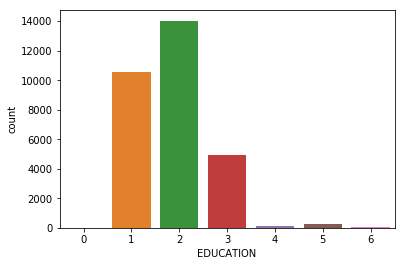

In [4]:
# 离散变量柱状图显示
sns.countplot(x = "EDUCATION", data = train_data)

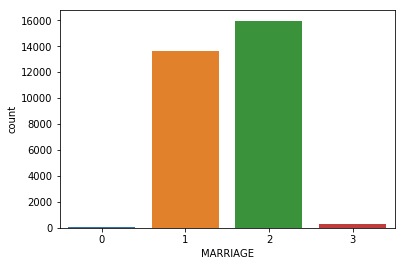

In [5]:
sns.countplot(x = "MARRIAGE", data = train_data)

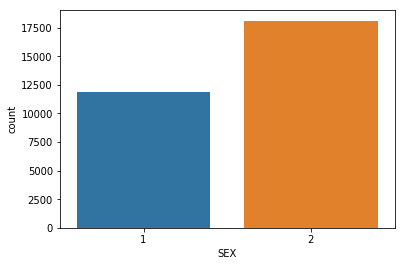

In [6]:
sns.countplot(x = "SEX", data = train_data)

## 类别变量--还款状态分析

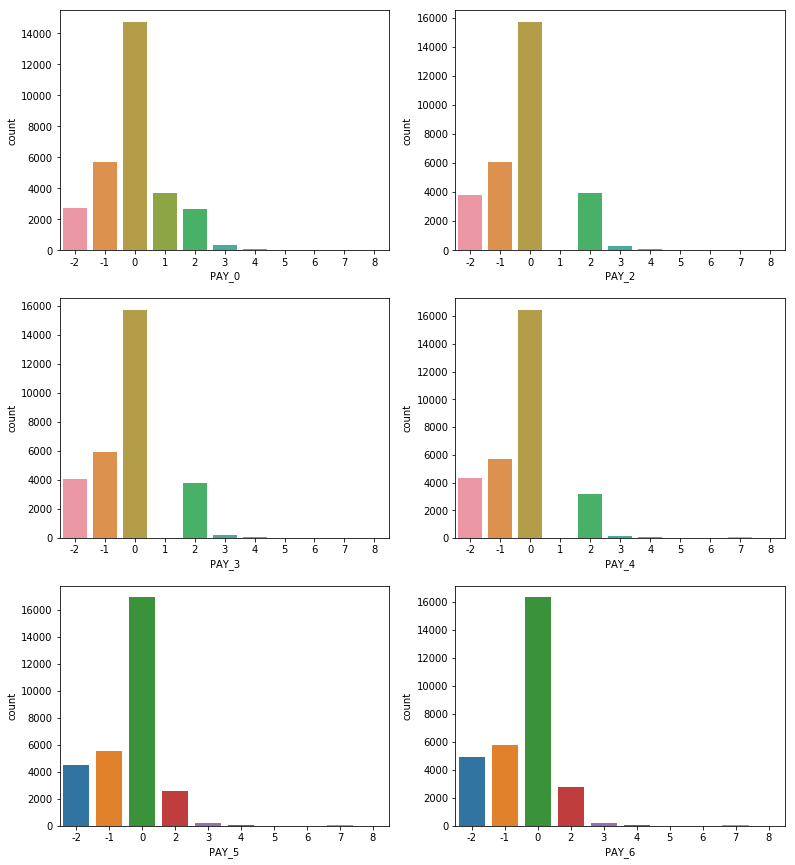

In [7]:
category_features = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
# 3 * 2 的 图形显示
indexi = 0
indexj = 0
f, axes = plt.subplots(3, 2, figsize=(13, 15))
for category_feature in category_features:
    sns.countplot(x=category_feature,data =train_data,ax=axes[indexi,indexj])
    if indexj == 1:
        indexi = indexi + 1
    if indexj == 0: 
        indexj = 1
    else:
        indexj = 0      

## 连续变量分布

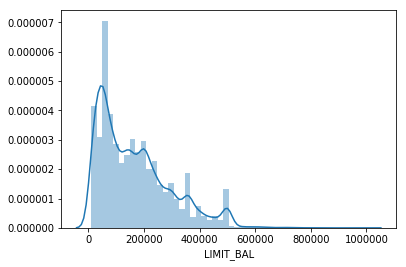

In [8]:
# 连续变量直方图展示
sns.distplot(train_data["LIMIT_BAL"])

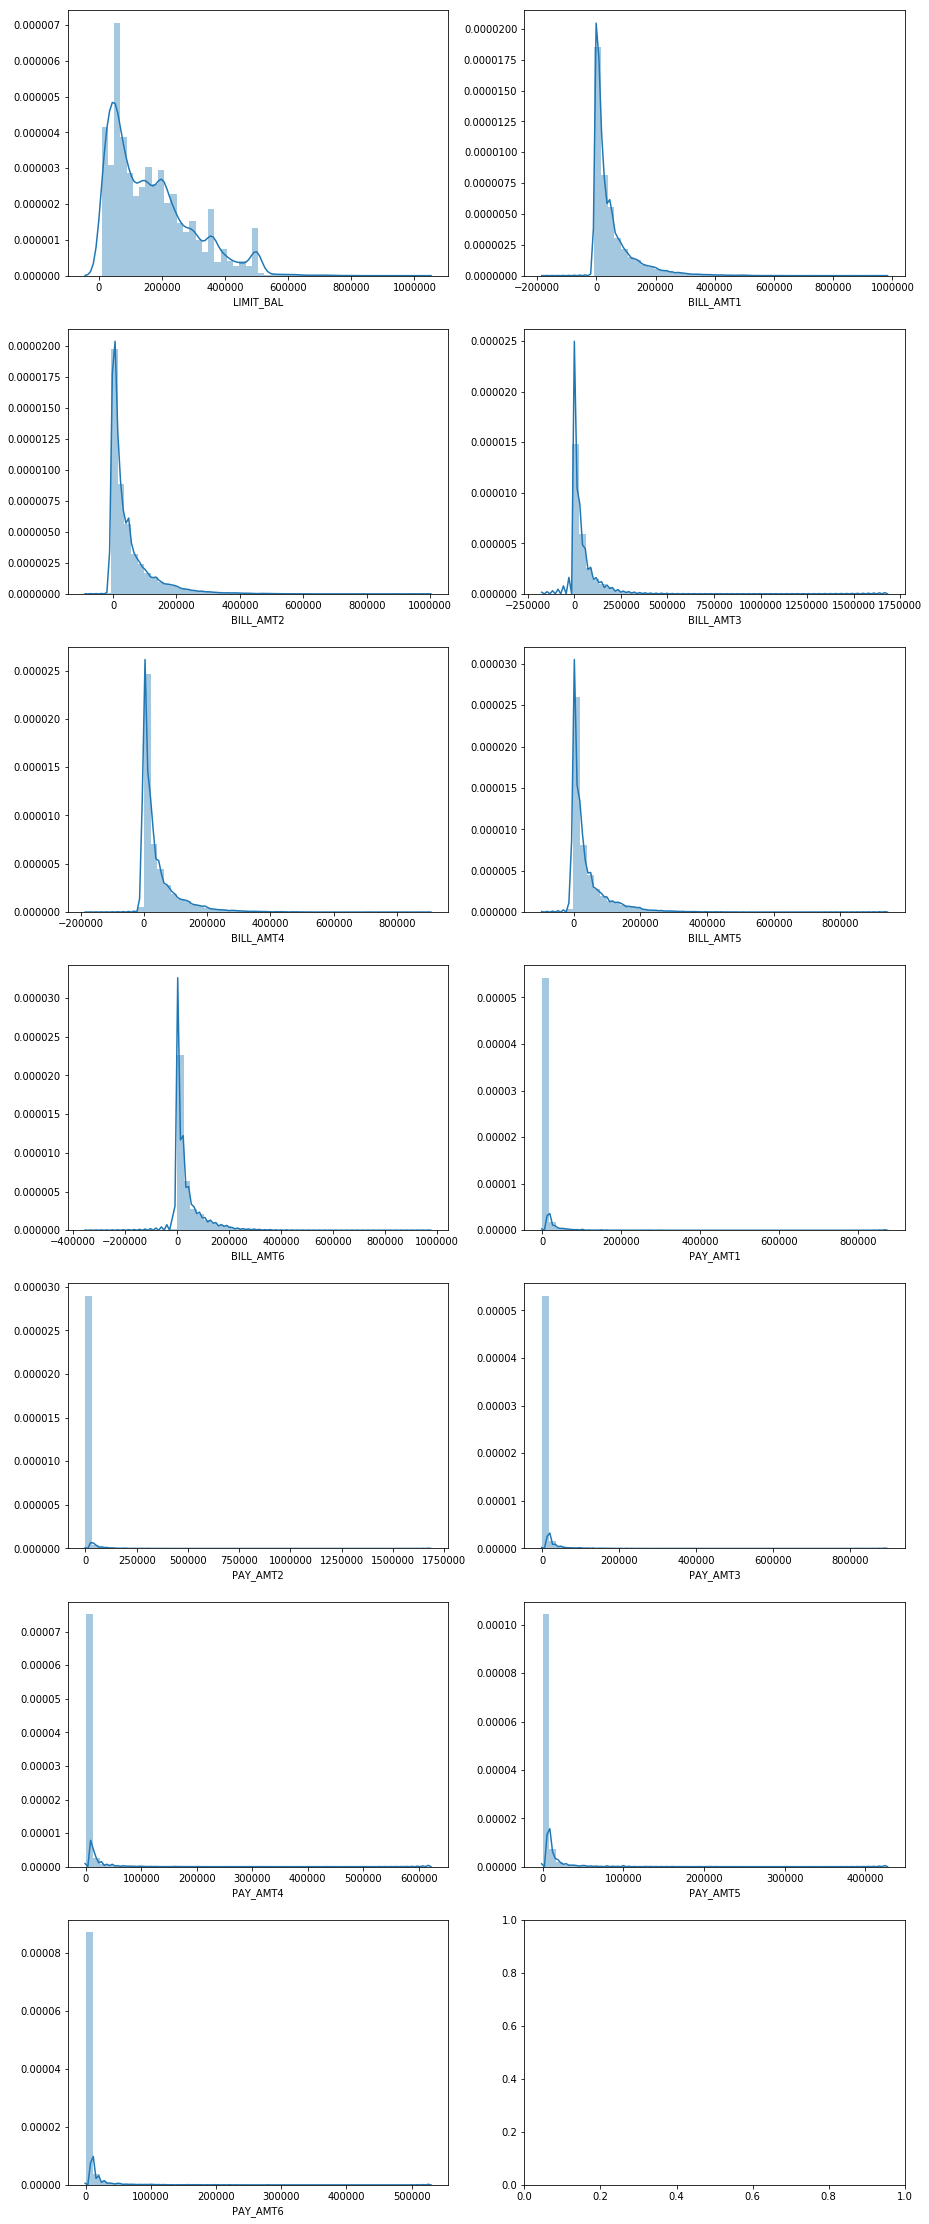

In [9]:
numeric_features = ["LIMIT_BAL","BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6","PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]

# 缺失值nan填充
# train_data_draw = train_data.where(train_data.notnull(), 0)
# train_data.fillna(0,inplace=True)
# print(train_data)
# # 12 * 4 的 图形显示
indexi = 0
indexj = 0
f, axes = plt.subplots(7, 2, figsize=(15, 40))
for numeric_feature in numeric_features:
    sns.distplot(a=train_data[numeric_feature],ax=axes[indexi,indexj])
    if indexj == 1:
        indexi = indexi + 1
    if indexj == 0: 
        indexj = 1
    else:
        indexj = 0 

# 数据处理

In [10]:
# EDUCATION 合并不明含义的字段
train_data.MARRIAGE = train_data.MARRIAGE.map({0:'unkown', 1:1, 2:0, 3:'unkown'})
train_data["EDUCATION"] = train_data["EDUCATION"].map({0: 'unkown',1:1,2:2,3:3,4:'unkown',5:'unkown',6: 'unkown'})
y = train_data['label']

# 特征变量处理

## 连续型变量，最优分箱

In [11]:
from CalWOE import woe_trans
from logistic_reg import logistic_reg
from logistic_reg import logit_output
from model_metrics import ks_stats
from model_metrics import plot_confusion_matrix
from model_metrics import plot_roc_curve
from model_metrics import lift_lorenz
from optimal_bining_MR import _applyBinMap
from optimal_bining_MR import applyMapCats
from optimal_bining_MR import binContVar
from optimal_bining_MR import reduceCats

# 取连续型变量
continnues = ['LIMIT_BAL', 'AGE','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# 数据分箱，对X变量作分箱处理
def data_bining(dc, y, method):
    """
    temp function for data bining
    """
    # pandas 创建 dataFrame
    new_ds = pd.DataFrame()
    # 变量每一列
    for v in dc.columns:
        x = dc[v]
        # 连续型变量最优分箱
        bin_map = binContVar(x, y, method)
        # 根据最优分箱，转换x变量
        new_x = _applyBinMap(x, bin_map)
        new_x.name = v + "_BIN"
        new_ds = pd.concat([new_ds, new_x], axis=1)
    return new_ds

# 连续变量最优分箱
new_dc = data_bining(train_data[continnues], y, method=4)

d:\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
D:\workspace\jupyter\optimal_bining_MR.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  newbinDS_0['i'] = range(1, len(newbinDS_0)+1)
D:\workspace\jupyter\optimal_bining_MR.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  newbinDS_1['i'] = range(1, len(newbinDS_1)+1)


In [12]:
new_dc.head()

,LIMIT_BAL_BIN,AGE_BIN,BILL_AMT1_BIN,BILL_AMT2_BIN,BILL_AMT3_BIN,BILL_AMT4_BIN,BILL_AMT5_BIN,BILL_AMT6_BIN,PAY_AMT1_BIN,PAY_AMT2_BIN,PAY_AMT3_BIN,PAY_AMT4_BIN,PAY_AMT5_BIN,PAY_AMT6_BIN
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,3,2,1,1,1,1,1,1,1,1,1,1,1,1
2,3,2,2,1,2,2,2,2,1,1,1,1,1,1
3,2,3,2,3,3,2,2,2,1,1,1,1,1,1
4,2,5,1,1,2,2,2,2,1,3,2,2,1,1


## 类别变量，降基处理

In [13]:
## catagory
characters = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
ds = train_data[characters]

# 降基处理
bin_maps_str = dict()
for var in ds.columns:
    x = ds[var]
    single_map = reduceCats(x, y, method=4)
    bin_maps_str[x.name] = single_map

# 根据降基结果做转换
new_PAY_0 = applyMapCats(train_data.PAY_0, bin_maps_str['PAY_0'])
new_PAY_3 = applyMapCats(train_data.PAY_3, bin_maps_str['PAY_3'])
new_PAY_4 = applyMapCats(train_data.PAY_4, bin_maps_str['PAY_4'])
new_PAY_5 = applyMapCats(train_data.PAY_5, bin_maps_str['PAY_5'])
new_PAY_6 = applyMapCats(train_data.PAY_6, bin_maps_str['PAY_6'])
new_PAY_2 = applyMapCats(train_data.PAY_2, bin_maps_str['PAY_2'])


D:\workspace\jupyter\optimal_bining_MR.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  newbinDS_0['i'] = range(1, len(newbinDS_0)+1)
D:\workspace\jupyter\optimal_bining_MR.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  newbinDS_1['i'] = range(1, len(newbinDS_1)+1)
D:\workspace\jupyter\optimal_bining_MR.py:201: RuntimeWarning: divide by zero encountered in log
  + ((n_21/n_s1) - (n_22/n_s2)) * np.log((n_21*n_s2)/(n_22*n_s1))
D:\workspace\jupyter\optimal_bining_MR.py:134: RuntimeWarning: divide by zero encountered in log
  *np.lo

## 合并数据

In [14]:
new_df = pd.concat([new_dc,new_PAY_0,new_PAY_2,new_PAY_3,new_PAY_4,new_PAY_5,
                    new_PAY_6,train_data.SEX, train_data.EDUCATION, train_data.MARRIAGE], axis=1)

In [15]:
new_df.head()

,LIMIT_BAL_BIN,AGE_BIN,BILL_AMT1_BIN,BILL_AMT2_BIN,BILL_AMT3_BIN,BILL_AMT4_BIN,BILL_AMT5_BIN,BILL_AMT6_BIN,PAY_AMT1_BIN,PAY_AMT2_BIN,...,PAY_AMT6_BIN,PAY_0_BIN,PAY_2_BIN,PAY_3_BIN,PAY_4_BIN,PAY_5_BIN,PAY_6_BIN,SEX,EDUCATION,MARRIAGE
0,1,1,1,1,1,1,1,1,1,1,...,1,5,4,3,4,3,3,2,2,1
1,3,2,1,1,1,1,1,1,1,1,...,1,3,4,2,2,3,4,2,2,0
2,3,2,2,1,2,2,2,2,1,1,...,1,4,3,2,2,3,3,2,2,0
3,2,3,2,3,3,2,2,2,1,1,...,1,4,3,2,2,3,3,2,2,1
4,2,5,1,1,2,2,2,2,1,3,...,1,3,3,3,2,3,3,1,2,1


# WOE转换

In [16]:
# WOE 转换
df_woe_X, woe_maps, iv_values = woe_trans(new_df.columns, y, new_df)

In [17]:
#     df_woe_X.head()

In [18]:
print(iv_values)

{'LIMIT_BAL_BIN': 0.1785127882337296, 'AGE_BIN': 0.022002981429876826, 'BILL_AMT1_BIN': 0.0090490711998926342, 'BILL_AMT2_BIN': 0.010663735817871573, 'BILL_AMT3_BIN': 0.0079444167605833716, 'BILL_AMT4_BIN': 0.0081698114103985198, 'BILL_AMT5_BIN': 0.011027254763818873, 'BILL_AMT6_BIN': 0.012281358114295451, 'PAY_AMT1_BIN': 0.066783726198584803, 'PAY_AMT2_BIN': 0.056867193849721734, 'PAY_AMT3_BIN': 0.053009264068066816, 'PAY_AMT4_BIN': 0.044613933781966465, 'PAY_AMT5_BIN': 0.064121670885763954, 'PAY_AMT6_BIN': 0.052235120556280448, 'PAY_0_BIN': 0.87558485079714088, 'PAY_2_BIN': 0.54839425021485744, 'PAY_3_BIN': 0.41542899733166477, 'PAY_4_BIN': 0.36664658597274941, 'PAY_5_BIN': 0.33432050328425506, 'PAY_6_BIN': 0.29191161948576422, 'SEX': 0.0091795784606773269, 'EDUCATION': 0.037299052841630015, 'MARRIAGE': 0.0054333943412695328}


In [19]:
from sklearn.model_selection import train_test_split

varNames = df_woe_X.columns
woe_vars = varNames[varNames.str.endswith('_WOE')]
woe_df = df_woe_X[woe_vars]

"""
数据划分
"""
X_train, X_test, y_train, y_test = train_test_split(woe_df, y, test_size=0.33)

# 模型开发

In [20]:
# print(X_train)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9900 entries, 16398 to 2258
Data columns (total 23 columns):
LIMIT_BAL_BIN_WOE    9900 non-null float64
AGE_BIN_WOE          9900 non-null float64
BILL_AMT1_BIN_WOE    9900 non-null float64
BILL_AMT2_BIN_WOE    9900 non-null float64
BILL_AMT3_BIN_WOE    9900 non-null float64
BILL_AMT4_BIN_WOE    9900 non-null float64
BILL_AMT5_BIN_WOE    9900 non-null float64
BILL_AMT6_BIN_WOE    9900 non-null float64
PAY_AMT1_BIN_WOE     9900 non-null float64
PAY_AMT2_BIN_WOE     9900 non-null float64
PAY_AMT3_BIN_WOE     9900 non-null float64
PAY_AMT4_BIN_WOE     9900 non-null float64
PAY_AMT5_BIN_WOE     9900 non-null float64
PAY_AMT6_BIN_WOE     9900 non-null float64
PAY_0_BIN_WOE        9900 non-null float64
PAY_2_BIN_WOE        9900 non-null float64
PAY_3_BIN_WOE        9900 non-null float64
PAY_4_BIN_WOE        9900 non-null float64
PAY_5_BIN_WOE        9900 non-null float64
PAY_6_BIN_WOE        9900 non-null float64
SEX_WOE              9900 non

## 决策树

In [21]:
#importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

# create the classifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# do our predictions on the test
predictions = classifier.predict(X_test)
# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

0.81444444444444442

## 交叉验证

In [26]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBClassifier,XGBRegressor

# Validation function
n_folds = 5

# 交叉验证
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(woe_df.values)
    rmse= cross_val_score(model, woe_df.values, y, scoring="roc_auc", cv = kf)
    return(rmse)

# classifier_model = DecisionTreeClassifier(max_depth=10, random_state=14) 
# score = rmsle_cv(classifier_model)
# classifier list for the downsampled training set
clf_lists = [DecisionTreeClassifier(max_depth = 3), 
            RandomForestClassifier(n_estimators = 100), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()]

rlf_lists = [DecisionTreeRegressor(max_depth = 3), 
            RandomForestRegressor(n_estimators = 100), 
            AdaBoostRegressor(DecisionTreeRegressor(max_depth = 3), n_estimators = 100), 
            GradientBoostingRegressor(), 
            XGBRegressor()]

# 尝试不同算法
for rlf_list in rlf_lists:
    score = rmsle_cv(rlf_list)
    print(score)
    
    
print("################################")  


for clf_list in clf_lists:
    score = rmsle_cv(clf_list)
    print(score)

[ 0.68091394  0.68734825  0.73689239  0.72486179  0.71892376]
[ 0.69880709  0.70344948  0.73714023  0.72579404  0.72834578]
[ 0.67886195  0.68747122  0.73044088  0.71342796  0.70843345]
[ 0.75564691  0.75432602  0.79728488  0.78405343  0.78983694]
[ 0.75526253  0.75356868  0.79718086  0.7840879   0.78970588]
################################
[ 0.68044444  0.68836964  0.72881047  0.73319891  0.71996142]
[ 0.70705575  0.71161772  0.73687118  0.74102159  0.73722826]
[ 0.74220585  0.73778263  0.76624675  0.77656497  0.76660577]
[ 0.75508513  0.75323303  0.78822191  0.79398285  0.79093717]
[ 0.75558112  0.75399903  0.7870992   0.79298737  0.79068426]


In [29]:
print(prob_y_test)

NameError: name 'prob_y_test' is not defined

## 特征变量重要性选择

In [30]:
imp  = classifier.feature_importances_.tolist()
result = pd.DataFrame({'feat':woe_df.columns,'score':imp})
result = result.sort_values(by=['score'],ascending=False)

## 根据统计量，训练模型

In [31]:
logit_instance, logit_model, logit_result, logit_result_0 = logistic_reg(X_train,
                                                                         y_train,
                                                                         stepwise='BS') # BS

desc, params, evaluate, quality = logit_output(logit_instance,
                                               logit_model,
                                               logit_result,
                                               logit_result_0)

Optimization terminated successfully.
         Current function value: 0.437392
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                20100
Model:                          Logit   Df Residuals:                    20076
Method:                           MLE   Df Model:                           23
Date:                Tue, 03 Apr 2018   Pseudo R-squ.:                  0.1786
Time:                        10:08:20   Log-Likelihood:                -8791.6
converged:                       True   LL-Null:                       -10704.
                                        LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2322      0.019    -64.043      0.000      -1.270      -1.195
LIMIT_BA

Optimization terminated successfully.
         Current function value: 0.437419
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                20100
Model:                          Logit   Df Residuals:                    20080
Method:                           MLE   Df Model:                           19
Date:                Tue, 03 Apr 2018   Pseudo R-squ.:                  0.1786
Time:                        10:08:21   Log-Likelihood:                -8792.1
converged:                       True   LL-Null:                       -10704.
                                        LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2321      0.019    -64.051      0.000      -1.270      -1.194
LIMIT_BA

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                20100
Model:                          Logit   Df Residuals:                    20084
Method:                           MLE   Df Model:                           15
Date:                Tue, 03 Apr 2018   Pseudo R-squ.:                  0.1783
Time:                        10:08:21   Log-Likelihood:                -8794.8
converged:                       True   LL-Null:                       -10704.
                                        LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.2312      0.019    -64.056      0.000      -1.269      -1.194
LIMIT_BAL_BIN_WOE     0.3314      0.052      6.375      0.000       0.230       0.433
AGE_BIN_WOE           0.

In [25]:
print(result)

                 feat     score
14      PAY_0_BIN_WOE  0.577226
15      PAY_2_BIN_WOE  0.117725
17      PAY_4_BIN_WOE  0.034946
0   LIMIT_BAL_BIN_WOE  0.033223
21      EDUCATION_WOE  0.024309
1         AGE_BIN_WOE  0.021880
16      PAY_3_BIN_WOE  0.021602
18      PAY_5_BIN_WOE  0.017968
19      PAY_6_BIN_WOE  0.016571
12   PAY_AMT5_BIN_WOE  0.014046
7   BILL_AMT6_BIN_WOE  0.013611
4   BILL_AMT3_BIN_WOE  0.013109
6   BILL_AMT5_BIN_WOE  0.012060
22       MARRIAGE_WOE  0.011906
20            SEX_WOE  0.010028
8    PAY_AMT1_BIN_WOE  0.009212
5   BILL_AMT4_BIN_WOE  0.009023
10   PAY_AMT3_BIN_WOE  0.008828
13   PAY_AMT6_BIN_WOE  0.008148
3   BILL_AMT2_BIN_WOE  0.007948
2   BILL_AMT1_BIN_WOE  0.007244
11   PAY_AMT4_BIN_WOE  0.006803
9    PAY_AMT2_BIN_WOE  0.002583


# 模型评估

## 混淆矩阵

In [39]:
# 测试数据集
X_test_metric = sm.add_constant(X_test[params.index[1:]])
# 测试数据结果
prob_y_test = logit_result.predict(X_test_metric)

In [40]:
# 结果集按阀值
label_pred_test = pd.np.where(prob_y_test > 0.5, 1, 0)

In [41]:
print(label_pred_test)

[0 0 0 ..., 0 0 0]


## KS曲线

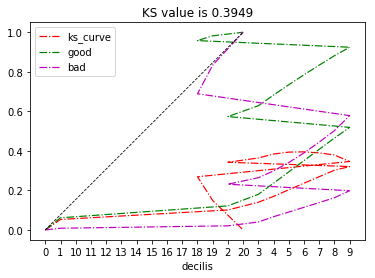

In [43]:
# KS表&KS曲线
ks_stattable, _ = ks_stats(prob_y_test, y_test)

## ROC曲线

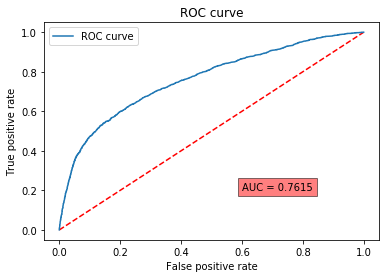

In [44]:
# ROC 曲线
plot_roc_curve(prob_y_test, y_test)

## 洛伦兹曲线

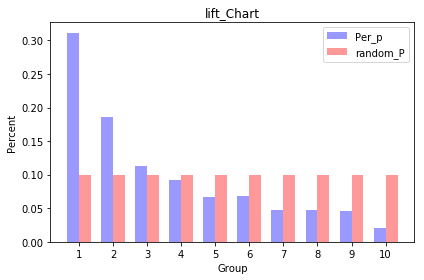

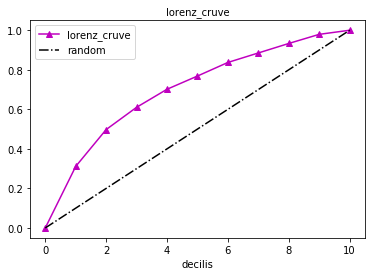

(None, None)

In [46]:
# 提升图&lorenz曲线
lift_lorenz(prob_y_test, y_test)

## 混淆矩阵

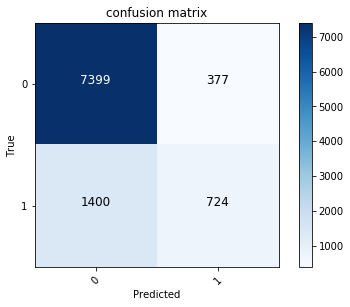

In [48]:
# 构造混淆矩阵
plot_confusion_matrix(y_test, label_pred_test, labels=[0,1])

# 评分卡制作

In [ ]:
##